In [ ]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely as sp
import random
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.cm as cm

Get Bounds of Initial Dataset

In [2]:
data_folder = Path("data/roadimages")
no_roads_folder = "1 _ No Roads"

file_paths = [file_path for file_path in data_folder.rglob("*") if file_path.is_file() and no_roads_folder not in file_path.parts]

file_names = [file_path.stem for file_path in data_folder.rglob("*") if file_path.is_file() and no_roads_folder not in file_path.parts]

file_parts = [file_name.split("_") for file_name in file_names]

sorted_file_parts = sorted(file_parts, key=lambda x: float(x[-1]))

min_lon = float(sorted_file_parts[0][-1])
max_lon = float(sorted_file_parts[-1][-1])
sorted_file_parts

sorted_file_parts = sorted(file_parts, key=lambda x: float(x[-2]))
min_lat = float(sorted_file_parts[0][-2])
max_lat = float(sorted_file_parts[-1][-2])
#sorted_file_parts


print("Minimum latitude:", min_lat)
print("Maximum latitude:", max_lat)

print("Minimum longitude:", min_lon)
print("Maximum longitude:", max_lon)

Minimum latitude: 14.501167
Maximum latitude: 14.69918
Minimum longitude: 120.963593
Maximum longitude: 121.105042


In [3]:
shape = gpd.read_file("data/shapefiles/gis_osm_roads_free_1.shp")
dataset_area = gpd.read_file("data/shapefiles/dataset_area.shp")

dataset_area

,geometry
0,"POLYGON ((120.93428 14.47773, 121.1335 14.4739..."


In [4]:
dataset_roads = shape[dataset_area['geometry'].item().contains(shape['geometry'])]

dataset_roads.count()

osm_id      142331
code        142331
fclass      142331
name         59119
ref           5241
oneway      142331
maxspeed    142331
layer       142331
bridge      142331
tunnel      142331
geometry    142331
dtype: int64

In [5]:
dataset_roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,267,5152,cycleway,Maharlika Street,None,B,25,0,F,F,"LINESTRING (121.05212 14.6503, 121.05223 14.65..."
2,2667097,5113,primary,Taft Avenue,170,F,60,0,F,F,"LINESTRING (120.99671 14.55627, 120.9967 14.55..."
3,2667099,5113,primary,Lerma Street,170,F,50,0,F,F,"LINESTRING (120.98539 14.6046, 120.98545 14.60..."
4,2667105,5122,residential,E. Manaloto Street,None,B,0,0,F,F,"LINESTRING (120.9938 14.54125, 120.99497 14.54..."
5,2667111,5113,primary,Quezon Boulevard,170,F,60,0,F,F,"LINESTRING (120.98018 14.59292, 120.98002 14.5..."


<Axes: >

<Axes: >

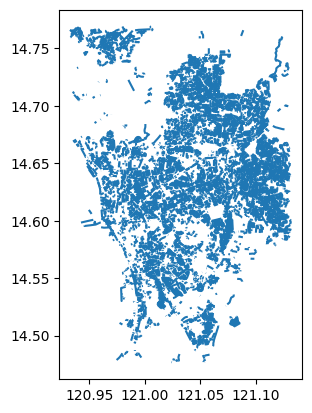

In [6]:
dataset_roads[:10000].plot()

In [7]:
dataset_roads['fclass'].unique()

array(['cycleway', 'primary', 'residential', 'secondary', 'tertiary',
       'motorway', 'trunk', 'primary_link', 'trunk_link', 'service',
       'unclassified', 'footway', 'steps', 'pedestrian', 'secondary_link',
       'motorway_link', 'tertiary_link', 'track', 'path', 'busway',
       'track_grade4', 'living_street', 'bridleway', 'track_grade5',
       'track_grade1'], dtype=object)

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
711,4483587,5122,residential,Zodiac Street,None,B,0,0,F,F,"LINESTRING (121.03515 14.55605, 121.03552 14.5..."
1370,4940456,5122,residential,Recoletos Street,None,B,0,0,F,F,"LINESTRING (121.03432 14.55529, 121.03434 14.5..."
5901,14712757,5113,primary,Kalayaan Overpass,191,F,60,1,T,F,"LINESTRING (121.03568 14.55571, 121.03538 14.5..."
7659,22882909,5115,tertiary,Jupiter Street,None,B,30,0,F,F,"LINESTRING (121.03501 14.55593, 121.03494 14.5..."
23798,28535210,5115,tertiary,Zodiac Street,None,B,30,0,F,F,"LINESTRING (121.03501 14.55593, 121.03485 14.5..."
23859,28538743,5112,trunk,EDSA,1,F,60,0,F,F,"LINESTRING (121.03549 14.55549, 121.03522 14.5..."
23975,28574025,5132,trunk_link,None,None,F,0,1,T,F,"LINESTRING (121.03487 14.55522, 121.03495 14.5..."
29108,29213181,5112,trunk,EDSA,1,F,60,0,F,F,"LINESTRING (121.03508 14.55511, 121.0349 14.55..."
29110,29213301,5113,primary,Kalayaan Overpass,191,F,60,1,T,F,"LINESTRING (121.03447 14.55542, 121.03459 14.5..."
173565,146300437,5113,primary,Senator Gil J. Puyat Avenue,190,F,40,0,F,F,"LINESTRING (121.03507 14.55532, 121.03501 14.5..."


,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
711,4483587,5122,residential,Zodiac Street,None,B,0,0,F,F,"LINESTRING (121.03515 14.55605, 121.03552 14.5..."
1370,4940456,5122,residential,Recoletos Street,None,B,0,0,F,F,"LINESTRING (121.03432 14.55529, 121.03434 14.5..."
5901,14712757,5113,primary,Kalayaan Overpass,191,F,60,1,T,F,"LINESTRING (121.03568 14.55571, 121.03538 14.5..."
7659,22882909,5115,tertiary,Jupiter Street,None,B,30,0,F,F,"LINESTRING (121.03501 14.55593, 121.03494 14.5..."
23798,28535210,5115,tertiary,Zodiac Street,None,B,30,0,F,F,"LINESTRING (121.03501 14.55593, 121.03485 14.5..."
23859,28538743,5112,trunk,EDSA,1,F,60,0,F,F,"LINESTRING (121.03549 14.55549, 121.03522 14.5..."
23975,28574025,5132,trunk_link,None,None,F,0,1,T,F,"LINESTRING (121.03487 14.55522, 121.03495 14.5..."
29108,29213181,5112,trunk,EDSA,1,F,60,0,F,F,"LINESTRING (121.03508 14.55511, 121.0349 14.55..."
29110,29213301,5113,primary,Kalayaan Overpass,191,F,60,1,T,F,"LINESTRING (121.03447 14.55542, 121.03459 14.5..."
173565,146300437,5113,primary,Senator Gil J. Puyat Avenue,190,F,40,0,F,F,"LINESTRING (121.03507 14.55532, 121.03501 14.5..."


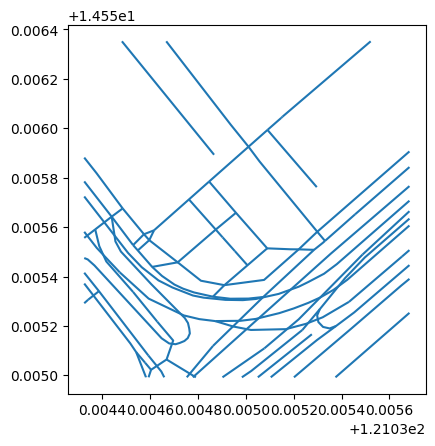

In [8]:
centerx, centery = (121.035004, 14.555672)

offset = 0.00068
minx, miny, maxx, maxy = (centerx - offset, centery - offset, centerx + offset, centery + offset)
bbox = sp.geometry.box(minx, miny, maxx, maxy)

road_patch = dataset_roads.cx[minx:maxx, miny:maxy]
road_patch.loc[:, 'geometry'] = road_patch['geometry'].apply(lambda geom: geom.intersection(bbox))
road_patch = road_patch[~road_patch.is_empty]

road_patch.plot()

road_patch

In [9]:
PATCH_SIZE = 512 # Size of the patches
EARTH_CIRCUFERENCE = 40075016.686 # in meters
SEARCH_INTERVAL = 50  # Distance between interpolated points
SEARCH_RANGE = 10 # pixels the road can be adjusted to find the best fit [coords-SEARCH_RANGE, coords+SEARCH_RANGE]
LINE_LENGTH = 20  # Total length of perpendicular lines
MAX_DISTANCE_FROM_ROAD = 50 # Maximum distance a point can be from a road mask
MAX_ROAD_WIDTH = 150 # Maximum width of a road for it to be considered
LAT_SIZE = 0.0013364 # Estimated degrees per 512 pixels (latitude)
LONG_SIZE = 0.00137216 # Estimated degrees per 512 pixels (longitude)

Display Random Patch

data\roadmasks\3__14.588900_121.045990.png
Random patch path: data\roadimages\2 _ Roads with Occlusions\3__14.588900_121.045990.png


data\roadmasks\3__14.588900_121.045990.png
Random patch path: data\roadimages\2 _ Roads with Occlusions\3__14.588900_121.045990.png


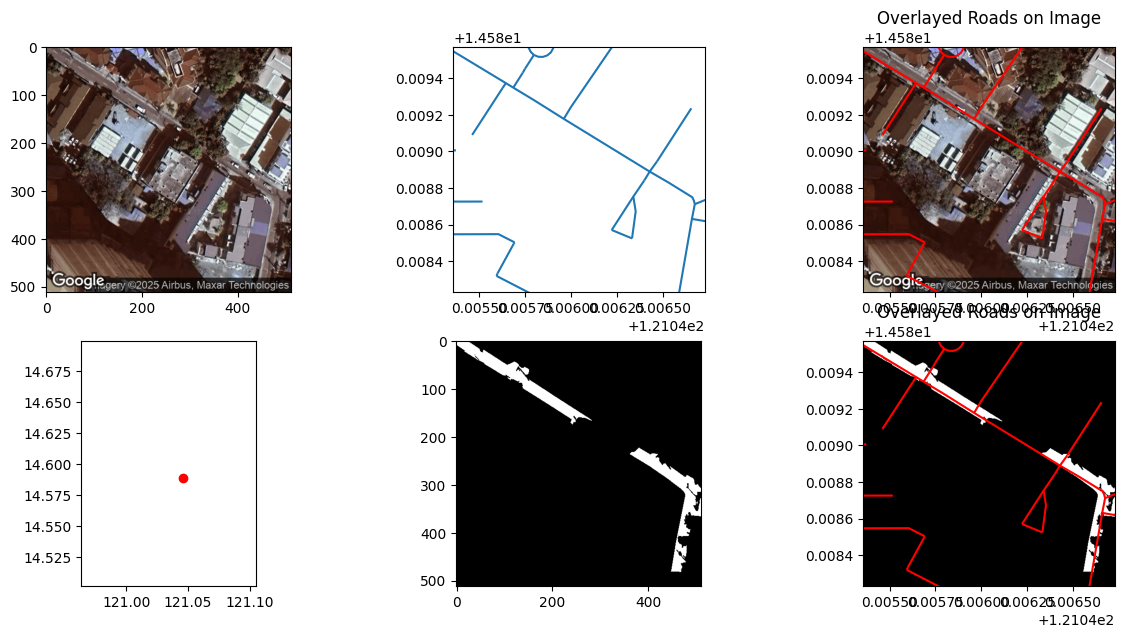

In [10]:
#get file paths
#data\roadimages\3 _ Clear Regular Roads\57__14.557001_121.006165.png
DISPLAY_ALLOWANCE = 0.0000

random_patch_path = random.choice(file_paths)
folder_names = ["\\1 _ No Roads", "\\2 _ Roads with Occlusions", "\\3 _ Clear Regular Roads", "\\4 _ Wide Roads"]
mask_path = str(random_patch_path).replace("roadimages", "roadmasks")

#remove folder names from mask paths
for folder_name in folder_names:
    mask_path = mask_path.replace(folder_name, "")
print(mask_path)

#set patch size
lat_size = LAT_SIZE/2
long_size = LONG_SIZE/2
#right = increase lon offset; up = increase lat offset
lat_shift = 0.0000
lon_shift = -0.000053
random_patch_lat = float(random_patch_path.stem.split("_")[-2])
random_patch_lon = float(random_patch_path.stem.split("_")[-1])

#adjust linestring coordinates 
minx, miny, maxx, maxy = (random_patch_lon - long_size, random_patch_lat - lat_size, random_patch_lon + long_size, random_patch_lat + lat_size)
minx = minx - lon_shift
maxx = maxx - lon_shift
miny = miny - lat_shift
maxy = maxy - lat_shift
bbox = sp.geometry.box(minx, miny, maxx, maxy)

#remove roads outside of patch
random_patch_roads = dataset_roads.cx[minx:maxx, miny:maxy]

print("Random patch path:", random_patch_path)

image = cv2.imread(str(random_patch_path))
mask_image = cv2.imread(str(mask_path))

if random_patch_roads.empty:
    print("No roads found in the random patch.")
    plt.imshow(image)
else:

    #show road patch
    fig, axes = plt.subplots(2, 3, figsize=(15, 7))
    axes[0][0].imshow(image)

    #plot linestrings (roadlines)
    random_patch_roads.plot(ax=axes[0][1])

    axes[0][1].set_xlim(minx-DISPLAY_ALLOWANCE, maxx+DISPLAY_ALLOWANCE)
    axes[0][1].set_ylim(miny-DISPLAY_ALLOWANCE, maxy+DISPLAY_ALLOWANCE)
    axes[0][1].set_aspect('equal')

    #overlay linestrings on patch
    axes[0][2].imshow(image, extent=[minx, maxx, miny, maxy])
    random_patch_roads.plot(ax=axes[0][2], color='red')
    axes[0][2].set_title("Overlayed Roads on Image")
    axes[0][2].set_xlim(minx-DISPLAY_ALLOWANCE, maxx+DISPLAY_ALLOWANCE)
    axes[0][2].set_ylim(miny-DISPLAY_ALLOWANCE, maxy+DISPLAY_ALLOWANCE)
    axes[0][2].set_aspect('equal')

    #coordinates relative to total dataset area
    axes[1][0].scatter(random_patch_lon, random_patch_lat, color='red')
    axes[1][0].set_xlim(min_lon, max_lon)
    axes[1][0].set_ylim(min_lat, max_lat)
    axes[1][0].set_aspect('equal')
    
    #ground truth mask
    axes[1][1].imshow(mask_image)

    #overlay linestrings on ground truth mask
    axes[1][2].imshow(mask_image, extent=[minx, maxx, miny, maxy])
    random_patch_roads.plot(ax=axes[1][2], color='red')
    axes[1][2].set_title("Overlayed Roads on Image")
    axes[1][2].set_xlim(minx, maxx)
    axes[1][2].set_ylim(miny, maxy)
    axes[1][2].set_aspect('equal')

    plt.show()


In [11]:
random_patch_roads

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
251,4263575,5115,tertiary,Lee Street,None,B,0,0,F,F,"LINESTRING (121.04647 14.58755, 121.04665 14.5..."
73485,82710486,5115,tertiary,Lee Street,None,B,0,0,F,F,"LINESTRING (121.04668 14.58871, 121.04667 14.5..."
635758,693127823,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04668 14.58871, 121.04714 14.5..."
639162,696080868,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04625 14.5896, 121.046 14.5892..."
639165,696080874,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04578 14.58954, 121.0458 14.58..."
639166,696080875,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04569 14.58935, 121.04574 14.5..."
639167,696080876,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04546 14.58909, 121.04563 14.5..."
639168,696080877,5122,residential,None,None,B,0,0,F,F,"LINESTRING (121.04634 14.58875, 121.04622 14.5..."
639175,696080888,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.0456 14.58833, 121.04559 14.58..."
639176,696080889,5141,service,None,None,B,0,0,F,T,"LINESTRING (121.04569 14.58849, 121.0456 14.58..."


In [12]:
#create scaled version of cropped linemap to fit mask
# Calculate scaling factors
# Function to scale geometries
def scale_geometry(geom, x_scale, y_scale):
    return sp.affinity.scale(geom, xfact=x_scale, yfact=y_scale, origin=(0,0))

def shift_geometry(geom, x_shift, y_shift):
    return sp.affinity.translate(geom, xoff=-x_shift, yoff=-y_shift)

# Create a copy of the GeoDataFrame and apply scaling to the copy
scaled_patch_roads = random_patch_roads.copy()

scaled_patch_roads["geometry_scaled"] = scaled_patch_roads["geometry"].apply(
    lambda geom: shift_geometry(geom, minx, miny)
)
scaled_patch_roads["geometry_scaled"] = scaled_patch_roads["geometry_scaled"].apply(
    lambda geom: scale_geometry(geom, 512/(maxx-minx), 512/(maxy-miny))
)

x_shift_initial = minx
y_shift_initial = miny
x_scale = 512/(maxx-minx)
y_scale = 512/(maxy-miny)

scaled_patch_roads

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,geometry_scaled
251,4263575,5115,tertiary,Lee Street,None,B,0,0,F,F,"LINESTRING (121.04647 14.58755, 121.04665 14.5...","LINESTRING (416.26119 -259.56301, 482.56716 13..."
73485,82710486,5115,tertiary,Lee Street,None,B,0,0,F,F,"LINESTRING (121.04668 14.58871, 121.04667 14.5...","LINESTRING (491.93284 183.7821, 489.91791 191...."
635758,693127823,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04668 14.58871, 121.04714 14.5...","LINESTRING (491.93284 183.7821, 666.44776 256...."
639162,696080868,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04625 14.5896, 121.046 14.5892...","LINESTRING (332.64179 525.98384, 239.54478 386..."
639165,696080874,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04578 14.58954, 121.0458 14.58...","LINESTRING (157.60448 502.30709, 164.39552 495..."
639166,696080875,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04569 14.58935, 121.04574 14.5...","LINESTRING (122.45522 427.33074, 141.85821 458..."
639167,696080876,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04546 14.58909, 121.04563 14.5...","LINESTRING (38.72388 328.40946, 100.62687 426...."
639168,696080877,5122,residential,None,None,B,0,0,F,F,"LINESTRING (121.04634 14.58875, 121.04622 14.5...","LINESTRING (366.8209 199.64322, 322.79104 129...."
639175,696080888,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.0456 14.58833, 121.04559 14.58...","LINESTRING (90.55224 39.3463, 88.35075 33.82939)"
639176,696080889,5141,service,None,None,B,0,0,F,T,"LINESTRING (121.04569 14.58849, 121.0456 14.58...","LINESTRING (123.12687 100.607, 90.55224 39.3463)"


In [13]:
def get_binary_mask_from_image(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image_mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return np.flipud(image_mask)

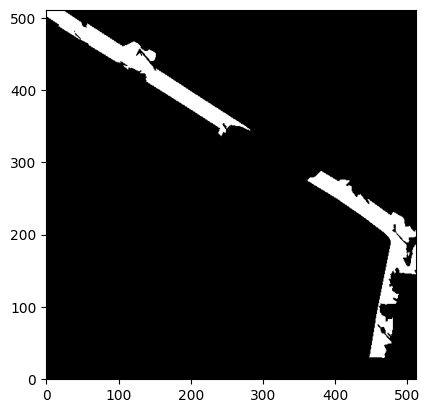

In [14]:
image_mask = get_binary_mask_from_image(mask_image)
plt.imshow(image_mask, cmap='gray')
plt.gca().invert_yaxis()

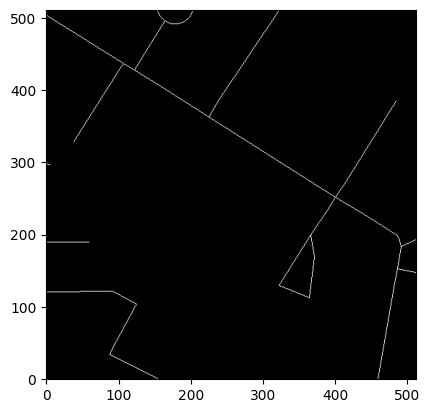

In [15]:
def get_binary_mask_from_roads(scaled_patch_roads):
    road_mask = np.zeros((512, 512), dtype=np.uint8)
    for geom in scaled_patch_roads["geometry_scaled"]:
        if geom.is_empty:
            continue
        if isinstance(geom, sp.LineString):
            coords = np.array(geom.coords, dtype=np.int32)
            cv2.polylines(road_mask, [coords], isClosed=False, color=1, thickness=1)
    return road_mask

road_mask = get_binary_mask_from_roads(scaled_patch_roads)
plt.imshow(road_mask, cmap='gray')
plt.gca().invert_yaxis()


In [17]:
def get_intersection(road_mask, image_mask):
    return np.sum((road_mask > 0) & (image_mask > 0))

In [18]:
shifted_road_masks = [[None for _ in range(2 * SEARCH_RANGE + 1)] for _ in range(2 * SEARCH_RANGE + 1)]

for i in range(-SEARCH_RANGE, SEARCH_RANGE + 1):
    for j in range(-SEARCH_RANGE, SEARCH_RANGE + 1):
        road_copy = scaled_patch_roads.copy()
        road_copy["geometry_scaled"] = road_copy["geometry_scaled"].apply(
            lambda geom: shift_geometry(geom, i, j)
        )
        road_mask = get_binary_mask_from_roads(road_copy)
        shifted_road_masks[i + SEARCH_RANGE][j + SEARCH_RANGE] = road_mask

max_intersection = -1
max_i = -1
max_j = -1

# Iterate through the shifted_road_masks to find the greatest intersection
for i in range(2 * SEARCH_RANGE + 1):
    for j in range(2 * SEARCH_RANGE + 1):
        road_mask = shifted_road_masks[i][j]
        intersection = get_intersection(road_mask, image_mask)
        if intersection > max_intersection:
            max_intersection = intersection
            max_i = i
            max_j = j

best_road_mask = shifted_road_masks[max_i][max_j]

best_shift_values = (max_i - SEARCH_RANGE, max_j - SEARCH_RANGE)


x_shift_second, y_shift_second = best_shift_values[0], best_shift_values[1]

print(f"Maximum intersection: {max_intersection}")
print(f"Shift coordinates: ({max_i - SEARCH_RANGE}, {max_j - SEARCH_RANGE})")

Maximum intersection: 636
Shift coordinates: (10, -10)


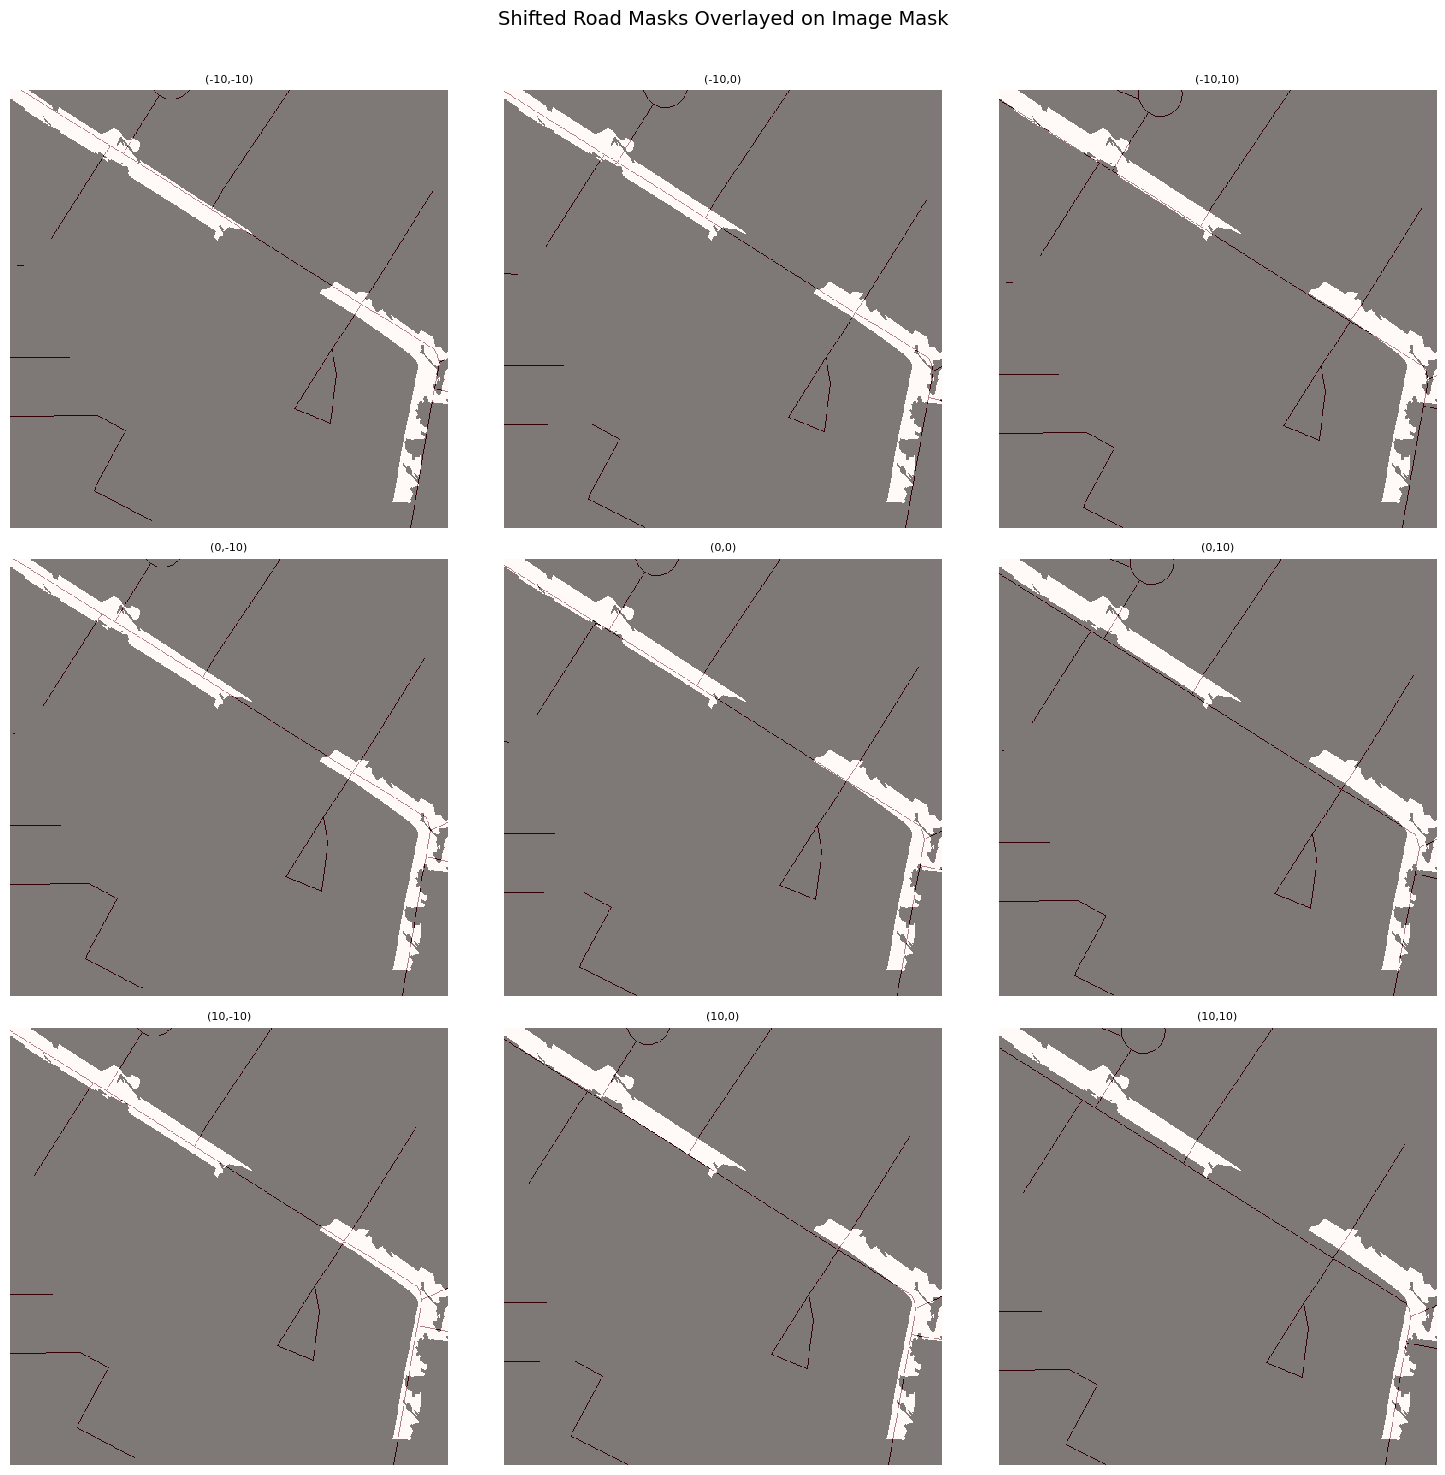

In [56]:
num_display = 3

fig, axes = plt.subplots(num_display, num_display, figsize=(15, 15))
for i in range(num_display):
    for j in range(num_display):
        ax = axes[i, j]
        num = (2 * SEARCH_RANGE)/(num_display-1)
        i_2 = int(i*num)
        j_2 = int(j*num)
        road_mask = shifted_road_masks[i_2][j_2]
        ax.imshow(image_mask, cmap='gray', interpolation='none')
        ax.imshow(road_mask, cmap='Reds', alpha=0.5, interpolation='none')
        ax.set_title(f"({i_2-SEARCH_RANGE},{j_2-SEARCH_RANGE})", fontsize=8)
        ax.axis('off')
        ax.invert_yaxis()
        ax.set_aspect('equal')

plt.suptitle("Shifted Road Masks Overlayed on Image Mask", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

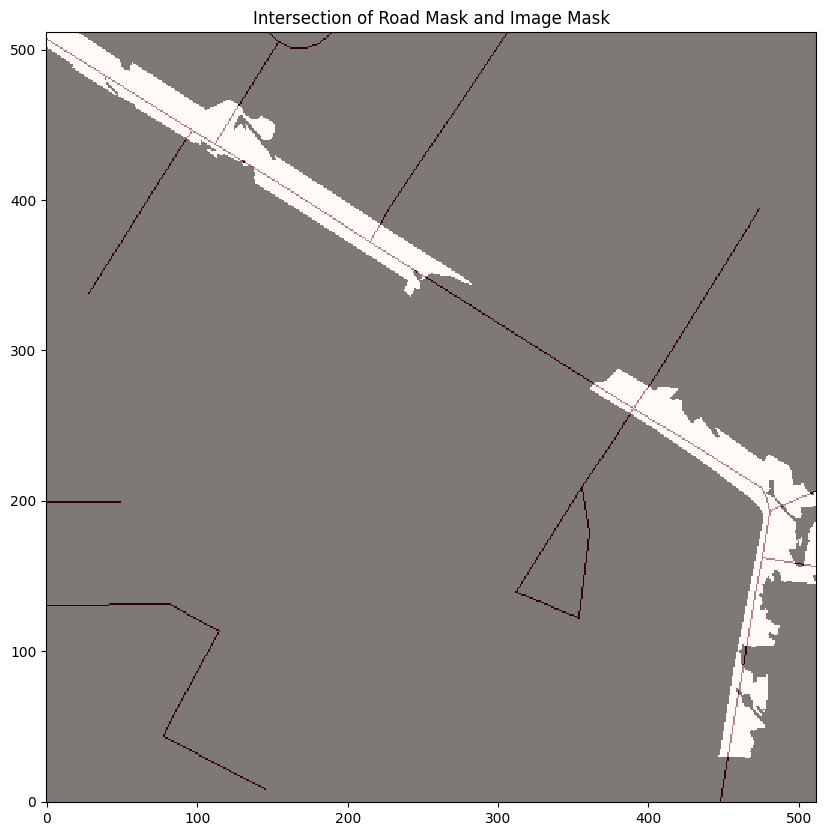

In [57]:
plt.figure(figsize=(10, 10))
plt.imshow(image_mask, cmap='gray', interpolation='none')
plt.imshow(best_road_mask, cmap='Reds', alpha=0.5, interpolation='none')  # Overlay road_mask in red with transparency
plt.title("Intersection of Road Mask and Image Mask")
plt.gca().invert_yaxis()
plt.show()

In [58]:
scaled_patch_roads["geometry_scaled"] = scaled_patch_roads["geometry_scaled"].apply(
    lambda geom: shift_geometry(geom, best_shift_values[0], best_shift_values[1])
)

scaled_patch_roads

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,geometry_scaled
251,4263575,5115,tertiary,Lee Street,None,B,0,0,F,F,"LINESTRING (121.04647 14.58755, 121.04665 14.5...","LINESTRING (396.26119 -239.56301, 462.56716 15..."
73485,82710486,5115,tertiary,Lee Street,None,B,0,0,F,F,"LINESTRING (121.04668 14.58871, 121.04667 14.5...","LINESTRING (471.93284 203.7821, 469.91791 211...."
635758,693127823,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04668 14.58871, 121.04714 14.5...","LINESTRING (471.93284 203.7821, 646.44776 276...."
639162,696080868,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04625 14.5896, 121.046 14.5892...","LINESTRING (312.64179 545.98384, 219.54478 406..."
639165,696080874,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04578 14.58954, 121.0458 14.58...","LINESTRING (137.60448 522.30709, 144.39552 515..."
639166,696080875,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04569 14.58935, 121.04574 14.5...","LINESTRING (102.45522 447.33074, 121.85821 478..."
639167,696080876,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.04546 14.58909, 121.04563 14.5...","LINESTRING (18.72388 348.40946, 80.62687 446.3..."
639168,696080877,5122,residential,None,None,B,0,0,F,F,"LINESTRING (121.04634 14.58875, 121.04622 14.5...","LINESTRING (346.8209 219.64322, 302.79104 149...."
639175,696080888,5141,service,None,None,B,0,0,F,F,"LINESTRING (121.0456 14.58833, 121.04559 14.58...","LINESTRING (70.55224 59.3463, 68.35075 53.82939)"
639176,696080889,5141,service,None,None,B,0,0,F,T,"LINESTRING (121.04569 14.58849, 121.0456 14.58...","LINESTRING (103.12687 120.607, 70.55224 59.3463)"


In [63]:
def interpolate_points(line, distance_interval):
    length = line.length
    num_points = math.ceil(length / distance_interval)
    distances = [i * distance_interval for i in range(num_points + 1)]
    points = [line.interpolate(distance) for distance in distances]
    #remove points that are out of bounds
    points = [point for point in points if point.x >= 0 and point.x < 512 and point.y >= 0 and point.y < 512]
    return points

In [67]:
def perpendicular_line_eq(line, point):
    coords = list(line.coords)

    for i in range(len(coords) - 1):
        x1, y1 = coords[i]
        x2, y2 = coords[i + 1]
        segment = sp.LineString([(x1, y1), (x2, y2)])

        if segment.distance(point) <= 1e-7:  # Check if point is close to the segment
            # Compute original slope
            if x2 - x1 == 0:  # Vertical line
                return (0, point.y)
            elif y2 - y1 == 0:  # Horizontal line
                return (float('inf'), point.x)
            
            slope = (y2 - y1) / (x2 - x1)
            perp_slope = -1 / slope  # Perpendicular slope

            x, y = point.x, point.y
            b = y - perp_slope * x

            return (perp_slope, b)
    
    return None

In [72]:
#gets point slope pairs of a road line
def compute_points_and_perpendiculars(road_line, distance_interval):
    point_slope_pairs = []
    points = interpolate_points(road_line, distance_interval)
    for point in points:
                perp_result = perpendicular_line_eq(road_line, point)
                if perp_result is not None:
                    slope, intercept = perp_result
                    point_slope_pairs.append((point, slope))
    return point_slope_pairs
    

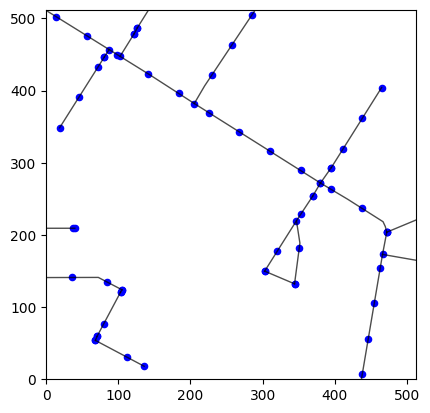

In [83]:
bbox = sp.geometry.box(0, 0, 512, 512)
point_line_eq = []
for road in scaled_patch_roads['geometry_scaled'].items():
    geom = road[1]
    
    if isinstance(geom, sp.MultiLineString):
        for line in geom.geoms:
            # Plot the line being interpolated
            x, y = line.xy
            plt.plot(x, y, color='black', linewidth=1, alpha=0.7)
            point_slope_pairs = compute_points_and_perpendiculars(line, SEARCH_INTERVAL)
            for point_slope_pair in point_slope_pairs:
                point, slope = point_slope_pair
                # if slope == float('inf'):
                #     x1, x2 = point.x, point.x
                #     y1, y2 = point.y - LINE_LENGTH / 2, point.y + LINE_LENGTH / 2
                #     plt.plot([x1, x2], [y1, y2], color='red')
                # else:
                #     dx = LINE_LENGTH / (2 * (1 + slope ** 2) ** 0.5)
                #     dy = slope * dx
                #     x1, y1 = point.x - dx, point.y - dy
                #     x2, y2 = point.x + dx, point.y + dy
                #     plt.plot([x1, x2], [y1, y2], color='red')
                plt.scatter(point.x, point.y, color='blue', s=20)
    elif isinstance(geom, sp.LineString):
        x, y = geom.xy
        plt.plot(x, y, color='black', linewidth=1, alpha=0.7)
        point_slope_pairs = compute_points_and_perpendiculars(geom, SEARCH_INTERVAL)
        for point_slope_pair in point_slope_pairs:
            point, slope = point_slope_pair
            point, slope = point_slope_pair
            # if slope == float('inf'):
            #     x1, x2 = point.x
            #     y1, y2 = point.y - LINE_LENGTH / 2, point.y + LINE_LENGTH / 2
            #     plt.plot([x1, x2], [y1, y2], color='red')
            # else:
            #     dx = LINE_LENGTH / (2 * (1 + slope ** 2) ** 0.5)
            #     dy = slope * dx
            #     x1, y1 = point.x - dx, point.y - dy
            #     x2, y2 = point.x + dx, point.y + dy
            #     plt.plot([x1, x2], [y1, y2], color='red')
            plt.scatter(point.x, point.y, color='blue', s=20)

plt.xlim(0, 512)
plt.ylim(0, 512)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
import math
import matplotlib.pyplot as plt

def measure_nearest_road_to_point(point, slope, image_mask, plot=True):
    min_distance = 2
    x, y = int(point.x), int(point.y)
    width, height = image_mask.shape  # Fix: Ensure correct order (height, width)

    # Check if the point is inside the image bounds
    if not (0 <= x < width and 0 <= y < height):
        return None  # Ensure point is within bounds

    search_mode = "inside" if image_mask[y, x] == 255 else "outside"
    points_forward = []
    points_backward = []

    if slope == float('inf'):  # **Vertical case**
        # Move upward (-y direction)
        found_white = False
        for i in range(y - 1, -1, -1):
            if search_mode == "inside" and (image_mask[i, x] == 0 or i == 0 or i == height - 1):
                points_backward.append((x, i))
                break
            if search_mode == "outside":
                if image_mask[i, x] == 255 and not found_white:
                    points_backward.append((x, i))
                    found_white = True
                    continue
                if found_white and image_mask[i, x] == 0:
                    points_backward.append((x, i))
                    break

        # Move downward (+y direction)
        found_white = False
        for i in range(y + 1, height):
            if search_mode == "inside" and (image_mask[i, x] == 0 or i == 0 or i == height - 1):
                points_forward.append((x, i))
                break
            if search_mode == "outside":
                if image_mask[i, x] == 255 and not found_white:
                    points_forward.append((x, i))
                    found_white = True
                    continue
                if found_white and image_mask[i, x] == 0:
                    points_forward.append((x, i))
                    break

    else:  # **Non-vertical case (diagonal/horizontal)**
        step_size = 1 / max(abs(slope), 1)  # Normalize step size
        dx = step_size if slope >= 0 else -step_size
        dy = slope * dx

        # Move forward
        xi, yi = x + dx, y + dy
        found_white = False
        while 0 <= int(round(xi)) < width and 0 <= int(round(yi)) < height:
            if search_mode == "inside" and (image_mask[int(round(yi)), int(round(xi))] == 0 or int(round(xi)) == 0 or int(round(xi)) == width - 1 or int(round(yi)) == 0 or int(round(yi)) == height - 1):
                points_forward.append((int(round(xi)), int(round(yi))))
                break
            if search_mode == "outside":
                if image_mask[int(round(yi)), int(round(xi))] == 255 and not found_white:
                    points_forward.append((int(round(xi)), int(round(yi))))
                    found_white = True
                    xi += dx
                    yi += dy
                    continue
                if found_white and image_mask[int(round(yi)), int(round(xi))] == 0:
                    points_forward.append((int(round(xi)), int(round(yi))))
                    break
            xi += dx
            yi += dy

        # Move backward
        xi, yi = x - dx, y - dy
        found_white = False
        while 0 <= int(round(xi)) < width and 0 <= int(round(yi)) < height:
            if search_mode == "inside" and (image_mask[int(round(yi)), int(round(xi))] == 0 or int(round(xi)) == 0 or int(round(xi)) == width - 1 or int(round(yi)) == 0 or int(round(yi)) == height - 1):
                points_backward.append((int(round(xi)), int(round(yi))))
                break
            if search_mode == "outside":
                if image_mask[int(round(yi)), int(round(xi))] == 255 and not found_white:
                    points_backward.append((int(round(xi)), int(round(yi))))
                    found_white = True
                    xi -= dx
                    yi -= dy
                    continue
                if found_white and image_mask[int(round(yi)), int(round(xi))] == 0:
                    points_backward.append((int(round(xi)), int(round(yi))))
                    break
            xi -= dx
            yi -= dy

    # **Visualization**
    if plot:
        plt.imshow(image_mask, cmap='gray')
        plt.scatter(x, y, color='red', label='Start Point', edgecolors='black', marker='o')
        if points_forward:
            plt.scatter(*zip(*points_forward), color='blue', label='Forward Boundary', edgecolors='black', marker='x')
        if points_backward:
            plt.scatter(*zip(*points_backward), color='green', label='Backward Boundary', edgecolors='black', marker='s')
        plt.gca().invert_yaxis()
        plt.legend()
        plt.show()

    # **Return total measured width**
    if search_mode == "inside":
        if points_forward and points_backward:
            total_dist = math.dist((point.x, point.y), points_forward[0]) + math.dist((point.x, point.y), points_backward[0])
            if total_dist > MAX_ROAD_WIDTH:
                return None
            return total_dist
    else:
        forward_dist = math.dist(points_forward[0], points_forward[1]) if len(points_forward) > 1 else None
        backward_dist = math.dist(points_backward[0], points_backward[1]) if len(points_backward) > 1 else None
        if forward_dist is not None and forward_dist > MAX_ROAD_WIDTH:
            forward_dist = None
        if backward_dist is not None and backward_dist > MAX_ROAD_WIDTH:
            backward_dist = None

        if forward_dist is not None and backward_dist is not None:
            if math.dist((point.x, point.y), points_forward[0]) < math.dist((point.x, point.y), points_backward[0]) and math.dist((point.x, point.y), points_forward[0]) < MAX_DISTANCE_FROM_ROAD and forward_dist > 1.1:
                return forward_dist
            elif math.dist((point.x, point.y), points_backward[0]) < MAX_DISTANCE_FROM_ROAD and backward_dist > 1.1:
                return backward_dist
        elif forward_dist is not None and forward_dist > 1.1 and math.dist((point.x, point.y), points_forward[0]) < MAX_DISTANCE_FROM_ROAD:
            return forward_dist
        elif backward_dist is not None and backward_dist > 1.1 and math.dist((point.x, point.y), points_backward[0]) < MAX_DISTANCE_FROM_ROAD:
            return backward_dist

    return None

In [73]:
def convert_coords(point_i):
    point = shift_geometry(point_i, -x_shift_second, -y_shift_second)
    point = scale_geometry(point, 1/x_scale, 1/y_scale)
    point = shift_geometry(point, -x_shift_initial, -y_shift_initial)
    return point

In [74]:
#get width measurements of one road line
def measure_road_width(line,  image_mask, plot=False):
    point_slope_pairs = compute_points_and_perpendiculars(line, SEARCH_INTERVAL)
    widths = []
    for point_slope_pair in point_slope_pairs:
        point, slope = point_slope_pair
        width = measure_nearest_road_to_point((point), slope, image_mask, plot=plot)
        coords = convert_coords(point)
        if width is not None:
            widths.append((point_slope_pair, coords, width))
    return widths

In [75]:
test = scaled_patch_roads.copy()
print(test["geometry"].iloc[0])
point = sp.Point(test["geometry_scaled"].iloc[0].coords[0])
print(convert_coords(point))

LINESTRING (121.0464725 14.5875543, 121.0466502 14.5885773, 121.0466595 14.5886311, 121.0466753 14.5887115)
POINT (121.04644569999999 14.587580401562501)


C:\Users\rafae_ls0opq0\AppData\Local\Temp\ipykernel_17264\1531866797.py:98: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(*zip(*points_forward), color='blue', label='Forward Boundary', edgecolors='black', marker='x')


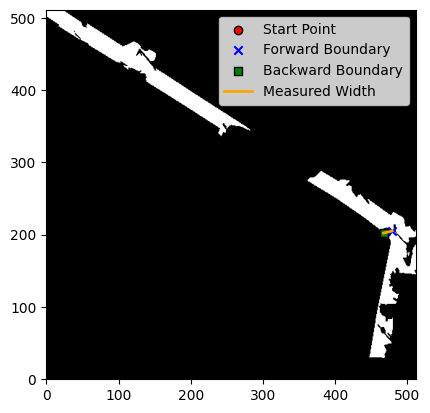

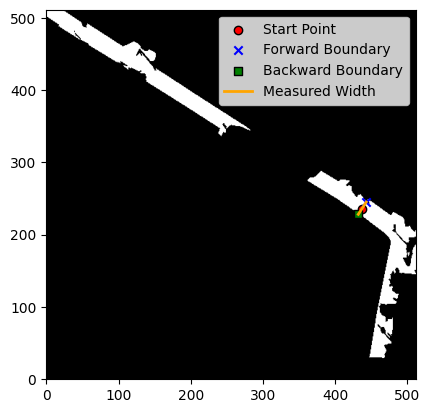

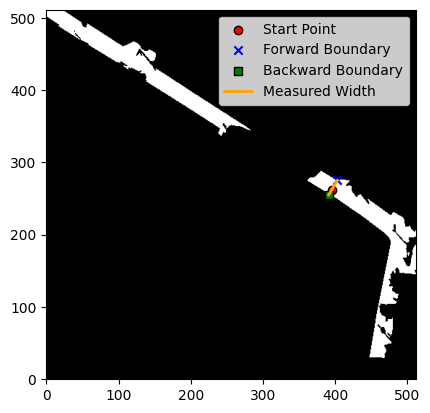

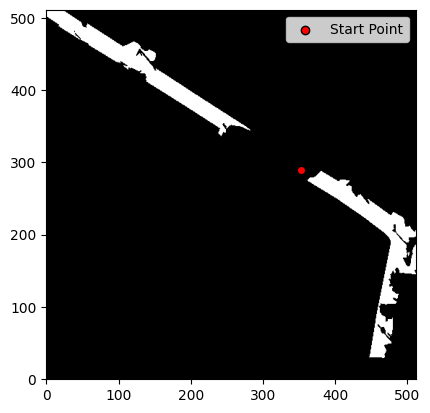

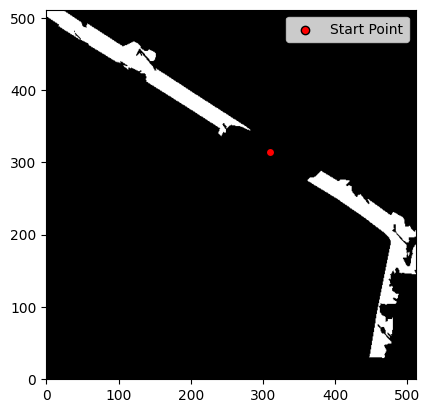

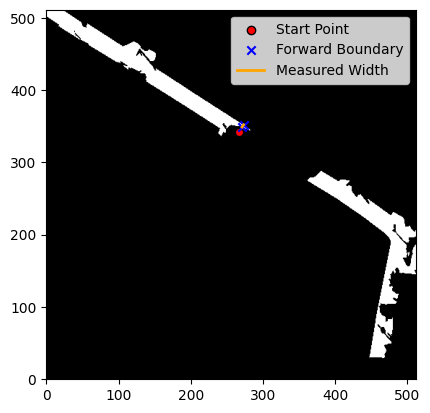

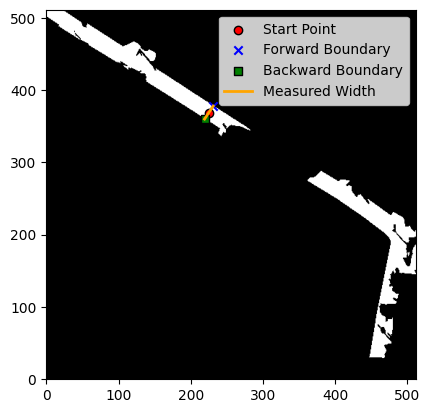

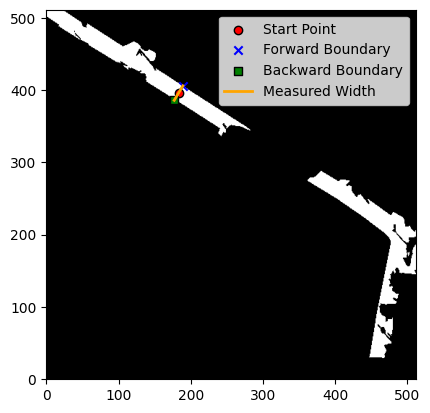

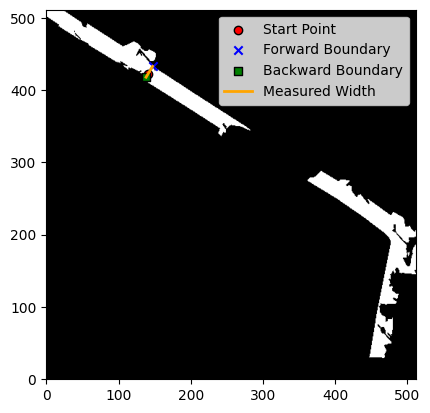

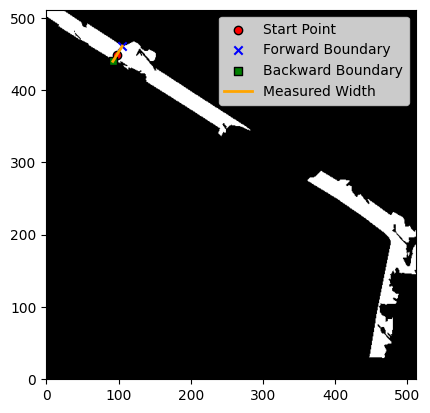

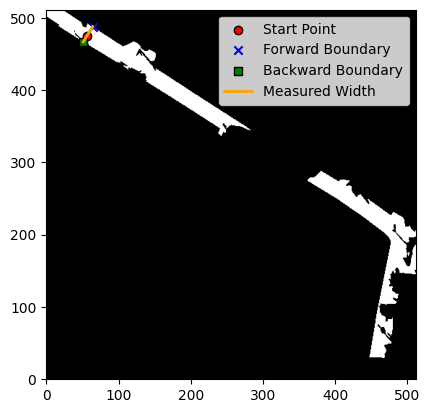

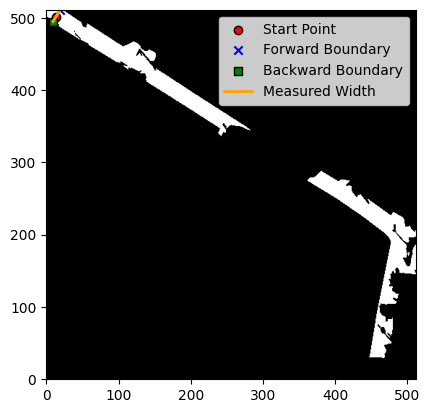

Average road width: 19.04 pixels


In [77]:
instance = scaled_patch_roads.iloc[1]
geom = instance['geometry_scaled']

if isinstance(geom, sp.MultiLineString):
    for line in geom.geoms:
        widths = measure_road_width(line, image_mask, True)
elif isinstance(geom, sp.LineString):
    widths = measure_road_width(geom, image_mask, True)

average_width = np.mean([width for _, _, width in widths])
print(f"Average road width: {average_width:.2f} pixels")

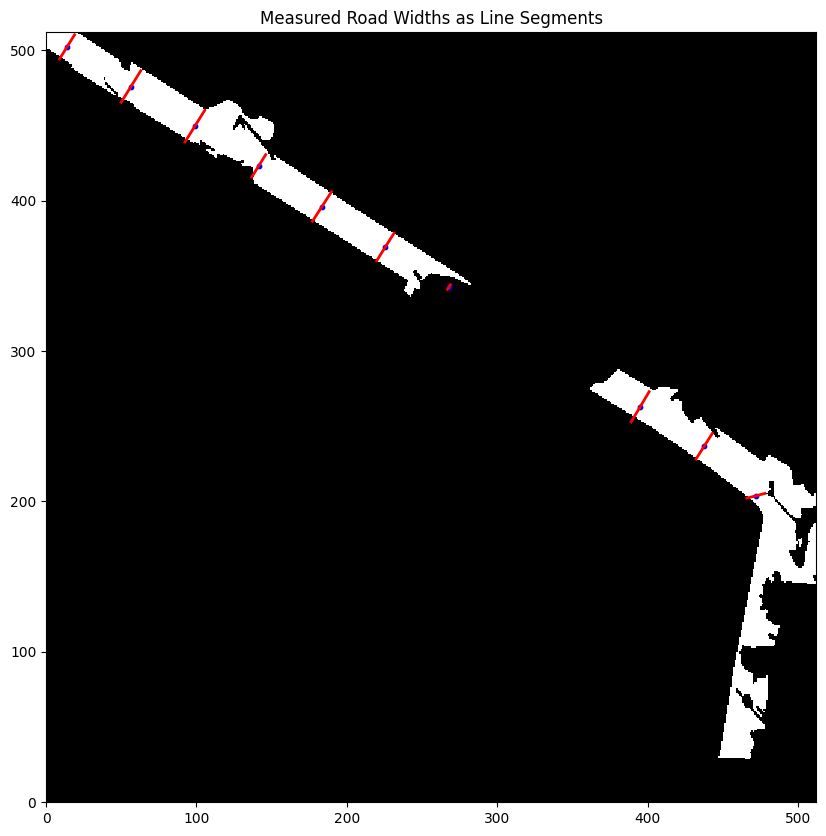

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_mask, cmap='gray', interpolation='none')

for width_info in widths:
    (point, slope), coords, width = width_info
    x0, y0 = point.x, point.y

    # Calculate dx, dy for the perpendicular line segment
    if slope == float('inf'):
        dx, dy = 0, width / 2
    elif slope == 0:
        dx, dy = width / 2, 0
    else:
        dx = (width / 2) / (1 + slope ** 2) ** 0.5
        dy = slope * dx 

    # Endpoints of the width segment
    x1, y1 = x0 - dx, y0 - dy
    x2, y2 = x0 + dx, y0 + dy

    ax.plot([x1, x2], [y1, y2], color='red', linewidth=2)
    ax.scatter([x0], [y0], color='blue', s=10)  # Mark the center point

ax.set_xlim(0, 512)
ax.set_ylim(0, 512)
ax.set_aspect('equal')
ax.set_title("Measured Road Widths as Line Segments")
plt.show()

In [ ]:
def get_patch_road_widths(roads, image_mask):
    road_widths = []
    for road in roads.itertuples():
        geom = road.geometry_scaled
        osm_id = road.osm_id
        if isinstance(geom, sp.MultiLineString):
            for line in geom.geoms:
                widths = measure_road_width(line, image_mask)
                road_widths.append((osm_id, widths))
        elif isinstance(geom, sp.LineString):
            widths = measure_road_width(geom, image_mask)
            road_widths.append((osm_id, widths))
    return road_widths

In [ ]:
def get_patch_road_widths_df(roads, image_mask):
    road_widths = []
    for road in roads.itertuples():
        geom = road.geometry_scaled
        osm_id = road.osm_id
        if isinstance(geom, sp.MultiLineString):
            for line in geom.geoms:
                widths = measure_road_width(line, image_mask)
                for point_slope_pair, coords, width in widths:
                    point, slope = point_slope_pair
                    road_widths.append({
                        'osm_id': osm_id,
                        'coordinates_on_image': point,
                        'map_coordinates': coords,
                        'slope': slope,
                        'width': width
                    })
        elif isinstance(geom, sp.LineString):
            widths = measure_road_width(geom, image_mask)
            for point_slope_pair, coords, width in widths:
                point, slope = point_slope_pair
                road_widths.append({
                    'osm_id': osm_id,
                    'coordinates_on_image': point,
                    'map_coordinates': coords,
                    'slope': slope,
                    'width': width
                })
    return pd.DataFrame(road_widths)


In [ ]:
patch_road_widths = get_patch_road_widths(scaled_patch_roads, image_mask)
patch_road_widths

[('27274182',
  [((<POINT (366.97 47.365)>, -0.017012452894229965),
    <POINT (121.046 14.562)>,
    30.01927769727972),
   ((<POINT (367.821 97.358)>, -0.017012452894229965),
    <POINT (121.046 14.562)>,
    30.019133930326433),
   ((<POINT (367.158 197.296)>, 0.05694869459141085),
    <POINT (121.046 14.562)>,
    29.023424942468914),
   ((<POINT (362.857 247.071)>, 0.1407003663528905),
    <POINT (121.046 14.562)>,
    28.29000452234042),
   ((<POINT (355.243 296.455)>, 0.2587025200504746),
    <POINT (121.046 14.562)>,
    23.836169724382078),
   ((<POINT (342.72 344.861)>, 0.2587025200504746),
    <POINT (121.046 14.563)>,
    119.82261749882892),
   ((<POINT (325.52 391.697)>, 0.41648519283235647),
    <POINT (121.046 14.563)>,
    29.165165772031372),
   ((<POINT (306.296 437.854)>, 0.41648519283235647),
    <POINT (121.046 14.563)>,
    28.28575731077652),
   ((<POINT (287.072 484.011)>, 0.41648519283235647),
    <POINT (121.046 14.563)>,
    26.000320450796643)]),
 ('2727418

In [ ]:
patch_road_widths_df = get_patch_road_widths_df(scaled_patch_roads, image_mask)
patch_road_widths_df

,osm_id,coordinates_on_image,map_coordinates,slope,width
0,27274182,POINT (366.970446671728 47.36478139296935),POINT (121.04636452079707 14.561752548230182),-0.017012,30.019278
1,27274182,POINT (367.82094624803875 97.35754737436605),POINT (121.04636680013594 14.561883037160763),-0.017012,30.019134
2,27274182,POINT (367.1581557526578 197.29594333559422),POINT (121.0463650238574 14.562143891989596),0.056949,29.023425
3,27274182,POINT (362.8567328085038 247.07116616637023),POINT (121.04635349604392 14.562273813098564),0.140700,28.290005
4,27274182,POINT (355.24334442030226 296.45470717240437),POINT (121.04633309216304 14.562402711856768),0.258703,23.836170
5,27274182,POINT (342.7204905734443 344.8610924075181),POINT (121.04629953091474 14.562529060085728),0.258703,119.822617
6,27274182,POINT (325.5195788031505 391.69697356089273),POINT (121.04625343247119 14.562651309053646),0.416485,29.165166
7,27274182,POINT (306.2959469663383 437.8537929812416),POINT (121.04620191313786 14.562771785564335),0.416485,28.285757
8,27274182,POINT (287.07231512952603 484.01061240159055),POINT (121.04615039380454 14.562892262075026),0.416485,26.000320
9,27274188,POINT (32.767111006124686 147.8169497825745),POINT (121.0454688558575 14.56201474408533),-1.402281,16.056379


In [ ]:
def generate_width_statistics(patch_road_widths_df):
    width_stats = patch_road_widths_df.groupby('osm_id')['width'].describe()
    return width_stats

In [ ]:
width_statistics = generate_width_statistics(patch_road_widths_df)
width_statistics

,count,mean,std,min,25%,50%,75%,max
osm_id,,,,,,,,
27274182,9.0,38.273541,30.646255,23.836170,28.285757,29.023425,30.019134,119.822617
27274188,4.0,47.715548,61.319894,12.139650,15.077197,19.642700,52.281051,139.437141
27274189,10.0,35.997398,27.313100,14.142136,23.334711,24.760207,29.920915,97.417514
27274191,3.0,25.248359,9.235626,14.596179,22.364473,30.132767,30.574449,31.016130
792461825,9.0,25.934382,4.313396,21.029389,23.079499,24.022377,29.011609,34.060942


In [ ]:
#calculate m per pixel: https://wiki.openstreetmap.org/wiki/Zoom_levels
def meters_per_pixel(lat):
    return EARTH_CIRCUFERENCE * abs(math.cos(math.radians(lat))) / (512 * (2 ** 18))

In [ ]:
avg_m_per_pixel = (meters_per_pixel(min_lat) + meters_per_pixel(max_lat)) / 2
(1/avg_m_per_pixel)

3.460925935231014